In [53]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [54]:
import pandas as pd
import numpy as np
from joblib import load
from preprocessor import *
from Preprocessor_LLM import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from transformers import pipeline
import torch
import re
import sys
import os


In [55]:
data = pd.read_csv('/home/onyxia/work/PROJET_STATAPP/Data/Cleans/Data_for_active_learning.csv')

X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

print(X.head())
print(y.head())


   Unnamed: 0    Make AccidentArea     Sex MaritalStatus  Age          Fault  \
0           0   Honda        Urban  Female        Single   21  Policy Holder   
1           1   Honda        Urban    Male        Single   34  Policy Holder   
2           2   Honda        Urban    Male       Married   47  Policy Holder   
3           3  Toyota        Rural    Male       Married   65    Third Party   
4           4   Honda        Urban  Female        Single   27    Third Party   

          PolicyType     VehiclePrice  Deductible  ...  Days_Policy_Accident  \
0  Sport - Liability  more than 69000         300  ...          more than 30   
1  Sport - Collision  more than 69000         400  ...          more than 30   
2  Sport - Collision  more than 69000         400  ...          more than 30   
3  Sedan - Liability   20000 to 29000         400  ...          more than 30   
4  Sport - Collision  more than 69000         400  ...          more than 30   

  PastNumberOfClaims AgeOfVehicle Poli

In [56]:
preprocessor = load("preprocessor.joblib")
print("✓ Preprocessor numérique chargé")

preprocessor_llm = PreprocessLLM(
    label_cols=label_cols,
    freq_cols=freq_cols,
    ordinal_cols=ordinal_cols,
    binary_cols=binary_cols,
    scale_cols=scale_cols
)

all_cols = binary_cols + label_cols + freq_cols + ordinal_cols + scale_cols
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_cols)

X_raw = X.copy()

print(f"  Données numériques: {X_preprocessed.shape}")
print(f"  Données brutes (pour LLM): {X_raw.shape}")

exemple_text = preprocessor_llm.transform(X_raw.head(1))
print("\n Exemple preprocessing LLM:")
print(exemple_text[0]['text'])

✓ Preprocessor numérique chargé
  Données numériques: (15419, 20)
  Données brutes (pour LLM): (15419, 21)

 Exemple preprocessing LLM:
Âge : 21 ans
Délai avant déclaration : 1 semaines
Sexe : Female
Zone de l'accident : Urban
Responsabilité : Policy Holder
Rapport de police : No
Présence de témoins : No
Type d'agent : External
VehiclePrice : more than 69000
Days_Policy_Accident : more than 30
PastNumberOfClaims : none
AgeOfVehicle : 3 years
NumberOfSuppliments : none
AddressChange_Claim : 1 year
NumberOfCars : 3 to 4
DriverRating : 1
Deductible : 300
PolicyType : Sport - Liability
Make : Honda
MaritalStatus : Single


Le preprocessor LLM sert à convertir en données textuelles les individus, de sorte que le LLM traite la base de données choisie.

In [57]:
# Split des données

# 20% pour le test
X_pool_full, X_test, y_pool_full, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, stratify=y, random_state=42
)

# De même pour les raw
X_raw_pool_full, X_raw_test, _, _ = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

# 2% d'observations initiales pour le seed
X_init, X_pool, y_init, y_pool = train_test_split(
    X_pool_full, y_pool_full, train_size=0.02, stratify=y_pool_full, random_state=42
)

# De même pour les raw
X_raw_init, X_raw_pool, _, _ = train_test_split(
    X_raw_pool_full, y_pool_full, train_size=0.02, stratify=y_pool_full, random_state=42
)

# Données pour uncertainty sampling
X_init_US = X_init.copy()
X_pool_US = X_pool.copy()
y_init_US = y_init.copy()
y_pool_US = y_pool.copy()

# Données pour LLM sampling
X_init_LLM = X_init.copy()
X_pool_LLM = X_pool.copy()
X_raw_pool_LLM = X_raw_pool.copy()
y_init_LLM = y_init.copy()
y_pool_LLM = y_pool.copy()

print(f"  Test set: {len(X_test)} observations")
print(f"  Pool initial: {len(X_pool)} observations")
print(f"  Seed initial: {len(X_init)} observations ({len(X_init)/len(X_pool_full)*100:.1f}%)")

  Test set: 3084 observations
  Pool initial: 12089 observations
  Seed initial: 246 observations (2.0%)


In [58]:
# CELLULE DE TEST
print("Test des imports:")

try:
    import torch
    print(f"✓ torch {torch.__version__}")
except Exception as e:
    print(f"❌ torch: {e}")

try:
    import transformers
    print(f"✓ transformers {transformers.__version__}")
except Exception as e:
    print(f"❌ transformers: {e}")

try:
    from transformers import pipeline
    print(f"✓ pipeline importable")
except Exception as e:
    print(f"❌ pipeline: {e}")

# Test simple
try:
    from transformers import pipeline
    test_pipeline = pipeline("text-generation", model="gpt2", max_new_tokens=10)
    result = test_pipeline("Hello", max_length=5)
    print(f"✓ Pipeline fonctionnel")
    print(f"  Résultat test: {result}")
except Exception as e:
    print(f"❌ Pipeline test: {e}")
    import traceback
    traceback.print_exc()

Test des imports:
✓ torch 2.10.0+cu128
✓ transformers 5.1.0
✓ pipeline importable


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 598.90it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=10) and `max_length`(=5) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✓ Pipeline fonctionnel
  Résultat test: [{'generated_text': 'Hello-We-Can-Save-The-Un'}]


In [59]:
# Initialisation des modèles et du SMOTE (par rapport à l'AL, ajout du model_LLM)

model = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)

model_US = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)

model_LLM = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)

# SMOTE
smote = SMOTE(sampling_strategy=0.25, random_state=42)

In [60]:
# ===========================
# INITIALISATION DU LLM
# ===========================
print("\n" + "="*60)
print("INITIALISATION DU LLM")
print("="*60)

# Vérifier torch
try:
    import torch
    print(f"✓ PyTorch {torch.__version__}")
    print(f"  CUDA disponible: {torch.cuda.is_available()}")
except ImportError:
    print("❌ PyTorch non installé")

llm = None

# Liste de modèles légers
models_to_try = [
    ("gpt2", 128),
    ("distilgpt2", 128),
]

for model_name, max_tokens in models_to_try:
    try:
        print(f"\nChargement: {model_name}...")
        
        # NE PAS passer le paramètre device - laisse transformers gérer automatiquement
        llm = pipeline(
            "text-generation",
            model=model_name,
            max_new_tokens=max_tokens,
            temperature=0.3,
            do_sample=True,
            top_p=0.9
        )
        
        print(f"✓ LLM initialisé: {model_name}")
        break
        
    except Exception as e:
        print(f"  ✗ Échec: {str(e)[:200]}")
        import traceback
        traceback.print_exc()
        continue

# Fallback
if llm is None:
    print("\n⚠ Fallback: Pseudo-LLM")
    
    class SimpleLLM:
        def __call__(self, prompt, **kwargs):
            import random
            match = re.search(r'sélectionner les (\d+)', prompt.lower())
            n_select = int(match.group(1)) if match else 50
            match_total = re.search(r'parmi (\d+) candidats', prompt.lower())
            n_total = int(match_total.group(1)) if match_total else 200
            
            step = max(1, n_total // n_select)
            indices = list(range(0, min(n_total, n_select * step), step))[:n_select]
            random.shuffle(indices)
            
            response = f"Indices sélectionnés: {indices}"
            return [{"generated_text": prompt + "\n" + response}]
    
    llm = SimpleLLM()
    print("✓ Pseudo-LLM initialisé")

print("="*60)


INITIALISATION DU LLM
✓ PyTorch 2.10.0+cu128
  CUDA disponible: False

Chargement: gpt2...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 510.52it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ LLM initialisé: gpt2


Ici, la partie fallback est utile dans le cas où torch rencontre un problème : il peut arriver que le module soit importé mais que vscode ne le reconnaisse pas, dans ce cas on fait usage du pseudo-LLM dans le modèle. 

In [61]:
# ===========================
# BOUCLE D'ACTIVE LEARNING
# ===========================
results = []
iteration = 0

print("\n" + "="*60)
print("DÉBUT DE LA BOUCLE D'ACTIVE LEARNING")
print("="*60)

while len(X_init) < 12089 and len(X_pool) > 0:
    iteration += 1
    print(f"\n{'='*60}")
    print(f"ITERATION {iteration} - Labels: {len(X_init)}")
    print(f"{'='*60}")
    
    # ========== RESET DES INDEX (CRUCIAL) ==========
    X_pool = X_pool.reset_index(drop=True)
    y_pool = y_pool.reset_index(drop=True)
    X_pool_US = X_pool_US.reset_index(drop=True)
    y_pool_US = y_pool_US.reset_index(drop=True)
    X_pool_LLM = X_pool_LLM.reset_index(drop=True)
    X_raw_pool_LLM = X_raw_pool_LLM.reset_index(drop=True)
    y_pool_LLM = y_pool_LLM.reset_index(drop=True)
    
    # ---- SMOTE ----
    X_init_smote, y_init_smote = smote.fit_resample(X_init, y_init)
    X_init_US_smote, y_init_US_smote = smote.fit_resample(X_init_US, y_init_US)
    X_init_LLM_smote, y_init_LLM_smote = smote.fit_resample(X_init_LLM, y_init_LLM)
    
    # ---- Entraînement ----
    model.fit(X_init_smote, y_init_smote)
    model_US.fit(X_init_US_smote, y_init_US_smote)
    model_LLM.fit(X_init_LLM_smote, y_init_LLM_smote)
    
    # ---- Évaluation ----
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    y_test_US_pred = model_US.predict(X_test)
    y_test_US_proba = model_US.predict_proba(X_test)[:, 1]
    
    y_test_LLM_pred = model_LLM.predict(X_test)
    y_test_LLM_proba = model_LLM.predict_proba(X_test)[:, 1]
    
    # Stockage
    results.append({
        "labels_used": len(X_init),
        "accuracy_random_sampling": accuracy_score(y_test, y_test_pred),
        "f1_random_sampling": f1_score(y_test, y_test_pred),
        "recall_random_sampling": recall_score(y_test, y_test_pred),
        "precision_random_sampling": precision_score(y_test, y_test_pred),
        "auc_random_sampling": roc_auc_score(y_test, y_test_proba),
        "accuracy_uncertainty_sampling": accuracy_score(y_test, y_test_US_pred),
        "f1_uncertainty_sampling": f1_score(y_test, y_test_US_pred),
        "recall_uncertainty_sampling": recall_score(y_test, y_test_US_pred),
        "precision_uncertainty_sampling": precision_score(y_test, y_test_US_pred),
        "auc_uncertainty_sampling": roc_auc_score(y_test, y_test_US_proba),
        "accuracy_llm_sampling": accuracy_score(y_test, y_test_LLM_pred),
        "f1_llm_sampling": f1_score(y_test, y_test_LLM_pred),
        "recall_llm_sampling": recall_score(y_test, y_test_LLM_pred),
        "precision_llm_sampling": precision_score(y_test, y_test_LLM_pred),
        "auc_llm_sampling": roc_auc_score(y_test, y_test_LLM_proba)
    })
    
    print(f"AUC - Random: {results[-1]['auc_random_sampling']:.4f} | "
          f"US: {results[-1]['auc_uncertainty_sampling']:.4f} | "
          f"LLM: {results[-1]['auc_llm_sampling']:.4f}")
    
    # ---- Prédictions sur pools ----
    y_pool_proba = model.predict_proba(X_pool)[:, 1]
    y_pool_US_proba = model_US.predict_proba(X_pool_US)[:, 1]
    y_pool_LLM_proba = model_LLM.predict_proba(X_pool_LLM)[:, 1]
    
    # ========== RANDOM SAMPLING ==========
    print("\n[Random Sampling]")
    if len(X_pool) >= 50:
        x_batch, X_pool_new, y_batch, y_pool_new = train_test_split(
            X_pool, y_pool, train_size=50, stratify=y_pool, random_state=42
        )
        X_init = pd.concat([X_init, x_batch], ignore_index=True)
        y_init = pd.concat([y_init, y_batch], ignore_index=True)
        X_pool = X_pool_new
        y_pool = y_pool_new
        print(f"  +50 échantillons")
    else:
        print(f"  Pool épuisé")
        break
    
    # ========== UNCERTAINTY SAMPLING ==========
    print("\n[Uncertainty Sampling]")
    if len(X_pool_US) > 0:
        y_init_US_proba = model_US.predict_proba(X_init_US)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_init_US, y_init_US_proba)
        youden = tpr - fpr
        best_idx = np.argmax(youden)
        youden_threshold = thresholds[best_idx]
        
        dist_to_threshold = np.abs(y_pool_US_proba - youden_threshold)
        n_select = min(50, len(X_pool_US))
        query_idx = np.argsort(dist_to_threshold)[:n_select]
        
        X_new_US = X_pool_US.iloc[query_idx]
        y_new_US = y_pool_US.iloc[query_idx]
        X_init_US = pd.concat([X_init_US, X_new_US], ignore_index=True)
        y_init_US = pd.concat([y_init_US, y_new_US], ignore_index=True)
        
        # Suppression par masque
        mask = np.ones(len(X_pool_US), dtype=bool)
        mask[query_idx] = False
        X_pool_US = X_pool_US[mask].reset_index(drop=True)
        y_pool_US = y_pool_US[mask].reset_index(drop=True)
        
        print(f"  +{len(query_idx)} échantillons (seuil: {youden_threshold:.4f})")
    
    # ========== LLM SAMPLING ==========
    print("\n[LLM-based Sampling]")
    
    if len(X_pool_LLM) == 0:
        print("  Pool épuisé")
        continue
    
    try:
        # Présélection
        y_init_LLM_proba = model_LLM.predict_proba(X_init_LLM)[:, 1]
        fpr_llm, tpr_llm, thresholds_llm = roc_curve(y_init_LLM, y_init_LLM_proba)
        youden_llm = tpr_llm - fpr_llm
        best_idx_llm = np.argmax(youden_llm)
        youden_threshold_llm = thresholds_llm[best_idx_llm]
        
        dist_to_threshold_llm = np.abs(y_pool_LLM_proba - youden_threshold_llm)
        n_preselect = min(200, len(X_pool_LLM))
        preselect_idx = np.argsort(dist_to_threshold_llm)[:n_preselect]
        
        print(f"  Présélection: {n_preselect} candidats")
        
        # Conversion texte
        X_raw_preselect = X_raw_pool_LLM.iloc[preselect_idx]
        X_preselect_texts = preprocessor_llm.transform(X_raw_preselect)
        print(f"  Conversion: {len(X_preselect_texts)} textes")
        
        # Appel LLM
        n_final_select = min(50, len(X_preselect_texts))
        prompt = create_llm_prompt(X_preselect_texts, n_select=n_final_select)
        
        print(f"  LLM: sélection de {n_final_select}...")
        llm_response = llm(prompt, do_sample=True, top_p=0.9)
        llm_output = llm_response[0]['generated_text']
        
        # Parser
        raw_indices = parse_llm_response(llm_output, n_max=len(X_preselect_texts), fallback_n=n_final_select)
        selected_indices_in_preselect = [idx for idx in raw_indices if 0 <= idx < len(X_preselect_texts)]
        
        # Compléter
        while len(selected_indices_in_preselect) < n_final_select:
            remaining = [i for i in range(len(X_preselect_texts)) if i not in selected_indices_in_preselect]
            if not remaining:
                break
            selected_indices_in_preselect.append(np.random.choice(remaining))
        
        selected_indices_in_preselect = np.array(selected_indices_in_preselect[:n_final_select])
        final_query_idx = preselect_idx[selected_indices_in_preselect]
        
        # Extraction
        X_new_LLM = X_pool_LLM.iloc[final_query_idx]
        y_new_LLM = y_pool_LLM.iloc[final_query_idx]
        X_init_LLM = pd.concat([X_init_LLM, X_new_LLM], ignore_index=True)
        y_init_LLM = pd.concat([y_init_LLM, y_new_LLM], ignore_index=True)
        
        # Suppression par masque
        mask = np.ones(len(X_pool_LLM), dtype=bool)
        mask[final_query_idx] = False
        X_pool_LLM = X_pool_LLM[mask].reset_index(drop=True)
        X_raw_pool_LLM = X_raw_pool_LLM[mask].reset_index(drop=True)
        y_pool_LLM = y_pool_LLM[mask].reset_index(drop=True)
        
        print(f"  +{len(final_query_idx)} échantillons")
        
    except Exception as e:
        print(f"  ❌ ERREUR LLM: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*60)
print("BOUCLE TERMINÉE")
print("="*60)


DÉBUT DE LA BOUCLE D'ACTIVE LEARNING

ITERATION 1 - Labels: 246


[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Token indices sequence length is longer than the specified maximum sequence length for this model (1139 > 1024). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.6347 | US: 0.6347 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.9659)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 2 - Labels: 296
[LightGBM] [Info] Number of positive: 69, number of negative: 278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 347, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198847 -> initscore=-1.393515
[LightGBM] [Info] Start training from score -1.393515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 3 - Labels: 346
[LightGBM] [Info] Number of positive: 81, number of negative: 325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199507 -> initscore=-1.389376
[LightGBM] [Info] Start training from score -1.389376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.6786 | US: 0.6358 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4612)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 4 - Labels: 396


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 93, number of negative: 372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 465, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.6738 | US: 0.6215 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4611)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 5 - Labels: 446
[LightGBM] [Info] Number of positive: 104, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 523, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198853 -> initscore=-1.393480
[LightGBM] [Info] Start training from score -1.393480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.4413)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 6 - Labels: 496
[LightGBM] [Info] Number of positive: 116, number of negative: 466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 582, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199313 -> initscore=-1.390595
[LightGBM] [Info] Start training from score -1.390595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.6887 | US: 0.7191 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4288)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 7 - Labels: 546
[LightGBM] [Info] Number of positive: 128, number of negative: 513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199688 -> initscore=-1.388246
[LightGBM] [Info] Start training from score -1.388246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4428)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 8 - Labels: 596
[LightGBM] [Info] Number of positive: 140, number of negative: 560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7081 | US: 0.6696 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4470)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 9 - Labels: 646
[LightGBM] [Info] Number of positive: 151, number of negative: 607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199208 -> initscore=-1.391249
[LightGBM] [Info] Start training from score -1.391249


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7347 | US: 0.6925 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4215)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 10 - Labels: 696
[LightGBM] [Info] Number of positive: 163, number of negative: 654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199510 -> initscore=-1.389357
[LightGBM] [Info] Start training from score -1.389357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4322)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 11 - Labels: 746
[LightGBM] [Info] Number of positive: 175, number of negative: 701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199772 -> initscore=-1.387722
[LightGBM] [Info] Start training from score -1.387722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4485)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 12 - Labels: 796
[LightGBM] [Info] Number of positive: 187, number of negative: 748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7366 | US: 0.6815 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4203)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 13 - Labels: 846
[LightGBM] [Info] Number of positive: 198, number of negative: 795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199396 -> initscore=-1.390075
[LightGBM] [Info] Start training from score -1.390075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7522 | US: 0.6518 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4045)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 14 - Labels: 896


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 210, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 1052, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199620 -> initscore=-1.388672
[LightGBM] [Info] Start training from score -1.388672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4041)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 15 - Labels: 946
[LightGBM] [Info] Number of positive: 222, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199820 -> initscore=-1.387420
[LightGBM] [Info] Start training from score -1.387420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7254 | US: 0.6532 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3876)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 16 - Labels: 996
[LightGBM] [Info] Number of positive: 234, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1170, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 17 - Labels: 1046
[LightGBM] [Info] Number of positive: 245, number of negative: 983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199511 -> initscore=-1.389351
[LightGBM] [Info] Start training from score -1.389351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7355 | US: 0.7232 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4077)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 18 - Labels: 1096
[LightGBM] [Info] Number of positive: 257, number of negative: 1030
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1287, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199689 -> initscore=-1.388238
[LightGBM] [Info] Start training from score -1.388238


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC - Random: 0.7508 | US: 0.6989 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3925)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 19 - Labels: 1146


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 269, number of negative: 1077
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1346, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199851 -> initscore=-1.387223
[LightGBM] [Info] Start training from score -1.387223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC - Random: 0.7485 | US: 0.7267 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3981)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 20 - Labels: 1196


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 281, number of negative: 1124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1405, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7475 | US: 0.7253 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.4213)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 21 - Labels: 1246
[LightGBM] [Info] Number of positive: 292, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199590 -> initscore=-1.388860
[LightGBM] [Info] Start training from score -1.388860


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7462 | US: 0.7425 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3900)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 22 - Labels: 1296


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 304, number of negative: 1218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199737 -> initscore=-1.387938
[LightGBM] [Info] Start training from score -1.387938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7352 | US: 0.7428 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3625)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 23 - Labels: 1346
[LightGBM] [Info] Number of positive: 316, number of negative: 1265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 1581, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199873 -> initscore=-1.387085
[LightGBM] [Info] Start training from score -1.387085


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7338 | US: 0.7415 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3701)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 24 - Labels: 1396
[LightGBM] [Info] Number of positive: 328, number of negative: 1312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1640, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7311 | US: 0.7273 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3695)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 25 - Labels: 1446
[LightGBM] [Info] Number of positive: 339, number of negative: 1359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 1698, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199647 -> initscore=-1.388504
[LightGBM] [Info] Start training from score -1.388504


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/pyth

  ❌ ERREUR LLM: index out of range in self

ITERATION 26 - Labels: 1496
[LightGBM] [Info] Number of positive: 351, number of negative: 1406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 1757, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199772 -> initscore=-1.387718
[LightGBM] [Info] Start training from score -1.387718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3102)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 27 - Labels: 1546
[LightGBM] [Info] Number of positive: 363, number of negative: 1453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199890 -> initscore=-1.386983
[LightGBM] [Info] Start training from score -1.386983


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7401 | US: 0.7629 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3362)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 28 - Labels: 1596
[LightGBM] [Info] Number of positive: 375, number of negative: 1500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1875, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2926)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 29 - Labels: 1646
[LightGBM] [Info] Number of positive: 386, number of negative: 1547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 1933, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199690 -> initscore=-1.388235
[LightGBM] [Info] Start training from score -1.388235


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7437 | US: 0.7678 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3157)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 30 - Labels: 1696
[LightGBM] [Info] Number of positive: 398, number of negative: 1594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199799 -> initscore=-1.387550
[LightGBM] [Info] Start training from score -1.387550


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3053)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 31 - Labels: 1746
[LightGBM] [Info] Number of positive: 410, number of negative: 1641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199902 -> initscore=-1.386904
[LightGBM] [Info] Start training from score -1.386904


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7386 | US: 0.7868 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3075)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 32 - Labels: 1796
[LightGBM] [Info] Number of positive: 422, number of negative: 1688
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 2110, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/pyth

  ❌ ERREUR LLM: index out of range in self

ITERATION 33 - Labels: 1846
[LightGBM] [Info] Number of positive: 433, number of negative: 1735
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 2168, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199723 -> initscore=-1.388025
[LightGBM] [Info] Start training from score -1.388025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7460 | US: 0.7883 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2819)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 34 - Labels: 1896
[LightGBM] [Info] Number of positive: 445, number of negative: 1782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2227, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199820 -> initscore=-1.387417
[LightGBM] [Info] Start training from score -1.387417


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 407, number of negative: 1631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 2038, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199706 -> initscore=-1.388135
[LightGBM] [Info] Start training from score -1.388135
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2644)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 35 - Labels: 1946
[LightGBM] [Info] Number of positive: 457, number of negative: 1829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 2286, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199913 -> initscore=-1.386841
[LightGBM] [Info] Start training from score -1.386841


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 417, number of negative: 1669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2749)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 36 - Labels: 1996
[LightGBM] [Info] Number of positive: 469, number of negative: 1876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3209)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 37 - Labels: 2046
[LightGBM] [Info] Number of positive: 480, number of negative: 1923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 2403, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199750 -> initscore=-1.387856
[LightGBM] [Info] Start training from score -1.387856


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7526 | US: 0.7969 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.3118)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 38 - Labels: 2096
[LightGBM] [Info] Number of positive: 492, number of negative: 1970
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 2462, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199838 -> initscore=-1.387310
[LightGBM] [Info] Start training from score -1.387310


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2720)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 39 - Labels: 2146
[LightGBM] [Info] Number of positive: 504, number of negative: 2017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 2521, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199921 -> initscore=-1.386790
[LightGBM] [Info] Start training from score -1.386790


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2960)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 40 - Labels: 2196
[LightGBM] [Info] Number of positive: 516, number of negative: 2064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 2580, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2946)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 41 - Labels: 2246
[LightGBM] [Info] Number of positive: 527, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 2638, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199773 -> initscore=-1.387716
[LightGBM] [Info] Start training from score -1.387716


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 479, number of negative: 1918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2960)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 42 - Labels: 2296
[LightGBM] [Info] Number of positive: 539, number of negative: 2158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 2697, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199852 -> initscore=-1.387222
[LightGBM] [Info] Start training from score -1.387222


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 490, number of negative: 1961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 2451

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2653)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 43 - Labels: 2346
[LightGBM] [Info] Number of positive: 551, number of negative: 2205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 2756, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199927 -> initscore=-1.386748
[LightGBM] [Info] Start training from score -1.386748


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 500, number of negative: 2000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7596 | US: 0.7933 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2697)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 44 - Labels: 2396
[LightGBM] [Info] Number of positive: 563, number of negative: 2252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 2815, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7562 | US: 0.8021 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2518)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 45 - Labels: 2446
[LightGBM] [Info] Number of positive: 574, number of negative: 2299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 2873, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199791 -> initscore=-1.387600
[LightGBM] [Info] Start training from score -1.387600


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 522, number of negative: 2089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 2611, number of

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 46 - Labels: 2496
[LightGBM] [Info] Number of positive: 586, number of negative: 2346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 2932, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199864 -> initscore=-1.387147
[LightGBM] [Info] Start training from score -1.387147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2554)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 47 - Labels: 2546
[LightGBM] [Info] Number of positive: 598, number of negative: 2393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 2991, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199933 -> initscore=-1.386712
[LightGBM] [Info] Start training from score -1.386712


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2558)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 48 - Labels: 2596
[LightGBM] [Info] Number of positive: 610, number of negative: 2440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 3050, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2573)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 49 - Labels: 2646
[LightGBM] [Info] Number of positive: 621, number of negative: 2487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 3108, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199807 -> initscore=-1.387501
[LightGBM] [Info] Start training from score -1.387501


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 566, number of negative: 2264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 2830

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7681 | US: 0.8037 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2538)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 50 - Labels: 2696
[LightGBM] [Info] Number of positive: 633, number of negative: 2534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3167, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199874 -> initscore=-1.387084
[LightGBM] [Info] Start training from score -1.387084


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 576, number of negative: 2305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2431)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 51 - Labels: 2746
[LightGBM] [Info] Number of positive: 645, number of negative: 2581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 3226, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199938 -> initscore=-1.386682
[LightGBM] [Info] Start training from score -1.386682


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 587, number of negative: 2348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 2935

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7832 | US: 0.8136 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2540)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 52 - Labels: 2796
[LightGBM] [Info] Number of positive: 657, number of negative: 2628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 3285, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 598, number of negative: 2393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 2991, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199933 -> initscore=-1.386712
[LightGBM] [Info] Start training from score -1.386712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7810 | US: 0.7923 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2582)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 53 - Labels: 2846
[LightGBM] [Info] Number of positive: 668, number of negative: 2675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 3343, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199821 -> initscore=-1.387416
[LightGBM] [Info] Start training from score -1.387416


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2582)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 54 - Labels: 2896
[LightGBM] [Info] Number of positive: 680, number of negative: 2722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 3402, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199882 -> initscore=-1.387029
[LightGBM] [Info] Start training from score -1.387029


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 621, number of negative: 2486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2761)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 55 - Labels: 2946
[LightGBM] [Info] Number of positive: 692, number of negative: 2769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 3461, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199942 -> initscore=-1.386656
[LightGBM] [Info] Start training from score -1.386656


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 633, number of negative: 2533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2556)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 56 - Labels: 2996
[LightGBM] [Info] Number of positive: 704, number of negative: 2816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 644, number of negative: 2577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 57 - Labels: 3046
[LightGBM] [Info] Number of positive: 715, number of negative: 2863
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 3578, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199832 -> initscore=-1.387343
[LightGBM] [Info] Start training from score -1.387343


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 654, number of negative: 2618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2573)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 58 - Labels: 3096
[LightGBM] [Info] Number of positive: 727, number of negative: 2910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 3637, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199890 -> initscore=-1.386982
[LightGBM] [Info] Start training from score -1.386982


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 665, number of negative: 2662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 3327, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199880 -> initscore=-1.387046
[LightGBM] [Info] Start training from score -1.387046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7785 | US: 0.8049 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2384)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 59 - Labels: 3146
[LightGBM] [Info] Number of positive: 739, number of negative: 2957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 3696, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199946 -> initscore=-1.386633
[LightGBM] [Info] Start training from score -1.386633


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 676, number of negative: 2704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.2231)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 60 - Labels: 3196
[LightGBM] [Info] Number of positive: 751, number of negative: 3004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2104
[LightGBM] [Info] Number of data points in the train set: 3755, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 687, number of negative: 2749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 3436, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199942 -> initscore=-1.386658
[LightGBM] [Info] Start training from score -1.386658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7844 | US: 0.8194 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2383)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 61 - Labels: 3246
[LightGBM] [Info] Number of positive: 762, number of negative: 3051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2282
[LightGBM] [Info] Number of data points in the train set: 3813, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199843 -> initscore=-1.387278
[LightGBM] [Info] Start training from score -1.387278


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7822 | US: 0.8141 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2054)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 62 - Labels: 3296
[LightGBM] [Info] Number of positive: 774, number of negative: 3098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2282
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199897 -> initscore=-1.386940
[LightGBM] [Info] Start training from score -1.386940


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7845 | US: 0.8196 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2175)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 63 - Labels: 3346
[LightGBM] [Info] Number of positive: 786, number of negative: 3145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 3931, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199949 -> initscore=-1.386612
[LightGBM] [Info] Start training from score -1.386612


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 719, number of negative: 2876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2132)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 64 - Labels: 3396
[LightGBM] [Info] Number of positive: 798, number of negative: 3192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 3990, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 730, number of negative: 2920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2281)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 65 - Labels: 3446
[LightGBM] [Info] Number of positive: 809, number of negative: 3239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 4048, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199852 -> initscore=-1.387221
[LightGBM] [Info] Start training from score -1.387221


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 740, number of negative: 2962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 3702, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199892 -> initscore=-1.386970
[LightGBM] [Info] Start training from score -1.386970
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7785 | US: 0.8179 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2282)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 66 - Labels: 3496
[LightGBM] [Info] Number of positive: 821, number of negative: 3286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 4107, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199903 -> initscore=-1.386903
[LightGBM] [Info] Start training from score -1.386903


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7885 | US: 0.8153 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2044)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 67 - Labels: 3546
[LightGBM] [Info] Number of positive: 833, number of negative: 3333


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 4166, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199952 -> initscore=-1.386594
[LightGBM] [Info] Start training from score -1.386594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7943 | US: 0.8179 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2066)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 68 - Labels: 3596
[LightGBM] [Info] Number of positive: 845, number of negative: 3380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2306
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 775, number of negative: 3101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7877 | US: 0.8180 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2014)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 69 - Labels: 3646
[LightGBM] [Info] Number of positive: 856, number of negative: 3427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in the train set: 4283, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199860 -> initscore=-1.387170
[LightGBM] [Info] Start training from score -1.387170


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 786, number of negative: 3147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 3933

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2113)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 70 - Labels: 3696
[LightGBM] [Info] Number of positive: 868, number of negative: 3474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 4342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199908 -> initscore=-1.386870
[LightGBM] [Info] Start training from score -1.386870


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 797, number of negative: 3189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2235)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 71 - Labels: 3746
[LightGBM] [Info] Number of positive: 880, number of negative: 3521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 4401, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386578
[LightGBM] [Info] Start training from score -1.386578


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 809, number of negative: 3236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 4045, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from sc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1906)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 72 - Labels: 3796
[LightGBM] [Info] Number of positive: 892, number of negative: 3568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 4460, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7826 | US: 0.8155 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1981)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 73 - Labels: 3846
[LightGBM] [Info] Number of positive: 903, number of negative: 3615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 4518, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199867 -> initscore=-1.387125
[LightGBM] [Info] Start training from score -1.387125


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 831, number of negative: 3326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 4157, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199904 -> initscore=-1.386896
[LightGBM] [Info] Start training from sc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1906)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 74 - Labels: 3896
[LightGBM] [Info] Number of positive: 915, number of negative: 3662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 4577, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199913 -> initscore=-1.386841
[LightGBM] [Info] Start training from score -1.386841


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 843, number of negative: 3374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 4217, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199905 -> initscore=-1.386887
[LightGBM] [Info] Start training from score -1.386887
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7904 | US: 0.8054 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1894)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 75 - Labels: 3946
[LightGBM] [Info] Number of positive: 927, number of negative: 3709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 4636, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386564
[LightGBM] [Info] Start training from score -1.386564


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 855, number of negative: 3420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 4275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7881 | US: 0.8117 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1860)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 76 - Labels: 3996
[LightGBM] [Info] Number of positive: 939, number of negative: 3756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 4695, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1840)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 77 - Labels: 4046
[LightGBM] [Info] Number of positive: 950, number of negative: 3803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2328
[LightGBM] [Info] Number of data points in the train set: 4753, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199874 -> initscore=-1.387084
[LightGBM] [Info] Start training from score -1.387084


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7852 | US: 0.8135 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1900)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 78 - Labels: 4096
[LightGBM] [Info] Number of positive: 962, number of negative: 3850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 4812, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199917 -> initscore=-1.386814
[LightGBM] [Info] Start training from score -1.386814


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 888, number of negative: 3555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 4443, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199865 -> initscore=-1.387139
[LightGBM] [Info] Start training from score -1.387139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7909 | US: 0.8126 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2307)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 79 - Labels: 4146


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 974, number of negative: 3897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 4871, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199959 -> initscore=-1.386551
[LightGBM] [Info] Start training from score -1.386551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 900, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 80 - Labels: 4196
[LightGBM] [Info] Number of positive: 986, number of negative: 3944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 911, number of negative: 3647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 4558, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199868 -> initscore=-1.387117
[LightGBM] [Info] Start training from score -1.387117
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7901 | US: 0.8149 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1799)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 81 - Labels: 4246
[LightGBM] [Info] Number of positive: 997, number of negative: 3991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 4988, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199880 -> initscore=-1.387046
[LightGBM] [Info] Start training from score -1.387046


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 923, number of negative: 3692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4615, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1969)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 82 - Labels: 4296
[LightGBM] [Info] Number of positive: 1009, number of negative: 4038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 5047, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199921 -> initscore=-1.386790
[LightGBM] [Info] Start training from score -1.386790


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 934, number of negative: 3737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 4671, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386562
[LightGBM] [Info] Start training from score -1.386562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative:

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7888 | US: 0.8149 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2083)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 83 - Labels: 4346


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1021, number of negative: 4085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199961 -> initscore=-1.386539
[LightGBM] [Info] Start training from score -1.386539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1907)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 84 - Labels: 4396
[LightGBM] [Info] Number of positive: 1033, number of negative: 4132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 5165, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 957, number of negative: 3830
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 4787, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199916 -> initscore=-1.386817
[LightGBM] [Info] Start training from score -1.386817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7981 | US: 0.8154 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1907)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 85 - Labels: 4446
[LightGBM] [Info] Number of positive: 1044, number of negative: 4179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 5223, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199885 -> initscore=-1.387012
[LightGBM] [Info] Start training from score -1.387012


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 969, number of negative: 3877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 4846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199959 -> initscore=-1.386552
[LightGBM] [Info] Start training from score -1.386552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7902 | US: 0.8185 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1910)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 86 - Labels: 4496
[LightGBM] [Info] Number of positive: 1056, number of negative: 4226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199924 -> initscore=-1.386768
[LightGBM] [Info] Start training from score -1.386768


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 979, number of negative: 3919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 4898, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199878 -> initscore=-1.387060
[LightGBM] [Info] Start training from score -1.387060
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [In

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1746)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 87 - Labels: 4546
[LightGBM] [Info] Number of positive: 1068, number of negative: 4273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 5341, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199963 -> initscore=-1.386528
[LightGBM] [Info] Start training from score -1.386528


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 991, number of negative: 3966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 4957, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199919 -> initscore=-1.386799
[LightGBM] [Info] Start training from score -1.386799
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhea

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7943 | US: 0.8147 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2053)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 88 - Labels: 4596
[LightGBM] [Info] Number of positive: 1080, number of negative: 4320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2361
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1002, number of negative: 4010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 5012, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199920 -> initscore=-1.386793
[LightGBM] [Info] Start training from score -1.386793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1931)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 89 - Labels: 4646
[LightGBM] [Info] Number of positive: 1091, number of negative: 4367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 5458, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199890 -> initscore=-1.386982
[LightGBM] [Info] Start training from score -1.386982


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1014, number of negative: 4058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 50

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7970 | US: 0.8158 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2088)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 90 - Labels: 4696
[LightGBM] [Info] Number of positive: 1103, number of negative: 4414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 5517, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199927 -> initscore=-1.386748
[LightGBM] [Info] Start training from score -1.386748


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1026, number of negative: 4105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 5131, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199961 -> initscore=-1.386538
[LightGBM] [Info] Start training from score -1.386538
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7936 | US: 0.8129 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1824)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 91 - Labels: 4746
[LightGBM] [Info] Number of positive: 1115, number of negative: 4461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 5576, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199964 -> initscore=-1.386519
[LightGBM] [Info] Start training from score -1.386519


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1038, number of negative: 4153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 5191, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199961 -> initscore=-1.386535
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1887)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 92 - Labels: 4796
[LightGBM] [Info] Number of positive: 1127, number of negative: 4508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1049, number of negative: 4199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199886 -> initscore=-1.387009
[LightGBM] [Info] Start training from score -1.387009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[Lig

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1702)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 93 - Labels: 4846
[LightGBM] [Info] Number of positive: 1138, number of negative: 4555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 5693, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199895 -> initscore=-1.386953
[LightGBM] [Info] Start training from score -1.386953


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1061, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 5305, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7943 | US: 0.8051 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1815)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 94 - Labels: 4896
[LightGBM] [Info] Number of positive: 1150, number of negative: 4602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 5752, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199930 -> initscore=-1.386729
[LightGBM] [Info] Start training from score -1.386729


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1072, number of negative: 4290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 5362, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199925 -> initscore=-1.386761
[LightGBM] [Info] Start training from score -1.386761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1792)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 95 - Labels: 4946
[LightGBM] [Info] Number of positive: 1162, number of negative: 4649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 5811, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199966 -> initscore=-1.386509
[LightGBM] [Info] Start training from score -1.386509


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1083, number of negative: 4335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 5418, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199889 -> initscore=-1.386987
[LightGBM] [Info] Start training from score -1.386987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[L

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC - Random: 0.7910 | US: 0.8078 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1820)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 96 - Labels: 4996


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1174, number of negative: 4696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 5870, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1095, number of negative: 4380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5475, number of used features: 20
[L

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7865 | US: 0.8064 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.2030)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 97 - Labels: 5046
[LightGBM] [Info] Number of positive: 1185, number of negative: 4743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199899 -> initscore=-1.386927
[LightGBM] [Info] Start training from score -1.386927


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1106, number of negative: 4425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 5531, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199964 -> initscore=-1.386520
[LightGBM] [Info] Start training from score -1.386520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7823 | US: 0.7973 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1814)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 98 - Labels: 5096
[LightGBM] [Info] Number of positive: 1197, number of negative: 4790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Number of data points in the train set: 5987, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199933 -> initscore=-1.386712
[LightGBM] [Info] Start training from score -1.386712


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1117, number of negative: 4469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 5586, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199964 -> initscore=-1.386518
[LightGBM] [Info] Start training from score -1.386518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7941 | US: 0.7996 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1627)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 99 - Labels: 5146
[LightGBM] [Info] Number of positive: 1209, number of negative: 4837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2392
[LightGBM] [Info] Number of data points in the train set: 6046, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199967 -> initscore=-1.386501
[LightGBM] [Info] Start training from score -1.386501


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1127, number of negative: 4511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 5638, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199894 -> initscore=-1.386960
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7950 | US: 0.8017 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1651)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 100 - Labels: 5196
[LightGBM] [Info] Number of positive: 1221, number of negative: 4884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2389
[LightGBM] [Info] Number of data points in the train set: 6105, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1139, number of negative: 4558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 5697, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199930 -> initscore=-1.386733
[LightGBM] [Info] Start training from score -1.386733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7815 | US: 0.7990 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1899)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 101 - Labels: 5246
[LightGBM] [Info] Number of positive: 1232, number of negative: 4931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 6163, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199903 -> initscore=-1.386903
[LightGBM] [Info] Start training from score -1.386903


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1152, number of negative: 4608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1807)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 102 - Labels: 5296
[LightGBM] [Info] Number of positive: 1244, number of negative: 4978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2398
[LightGBM] [Info] Number of data points in the train set: 6222, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199936 -> initscore=-1.386696
[LightGBM] [Info] Start training from score -1.386696


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1164, number of negative: 4656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 5820, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7934 | US: 0.8060 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1713)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 103 - Labels: 5346
[LightGBM] [Info] Number of positive: 1256, number of negative: 5025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2401
[LightGBM] [Info] Number of data points in the train set: 6281, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199968 -> initscore=-1.386493
[LightGBM] [Info] Start training from score -1.386493


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1175, number of negative: 4701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1676)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 104 - Labels: 5396
[LightGBM] [Info] Number of positive: 1268, number of negative: 5072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 6340, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1187, number of negative: 4750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 5937, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199933 -> initscore=-1.386716
[LightGBM] [Info] Start training from score -1.386716
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7957 | US: 0.7999 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1815)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 105 - Labels: 5446
[LightGBM] [Info] Number of positive: 1279, number of negative: 5119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 6398, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199906 -> initscore=-1.386881
[LightGBM] [Info] Start training from score -1.386881


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1199, number of negative: 4797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 59

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7897 | US: 0.8097 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1849)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 106 - Labels: 5496
[LightGBM] [Info] Number of positive: 1291, number of negative: 5166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2401
[LightGBM] [Info] Number of data points in the train set: 6457, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199938 -> initscore=-1.386682
[LightGBM] [Info] Start training from score -1.386682


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1210, number of negative: 4842
[LightGBM] [Info] Auto-choosing

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7969 | US: 0.8058 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1687)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 107 - Labels: 5546
[LightGBM] [Info] Number of positive: 1303, number of negative: 5213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 6516, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199969 -> initscore=-1.386486
[LightGBM] [Info] Start training from score -1.386486


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1222, number of negative: 4891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 6113, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199902 -> initscore=-1.386908
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8035 | US: 0.8059 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1819)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 108 - Labels: 5596
[LightGBM] [Info] Number of positive: 1315, number of negative: 5260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1233, number of negative: 4934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 6167, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199935 -> initscore=-1.386700
[LightGBM] [Info] Start training from score -1.386700
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8061 | US: 0.8104 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1720)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 109 - Labels: 5646
[LightGBM] [Info] Number of positive: 1326, number of negative: 5307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 6633, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199910 -> initscore=-1.386860
[LightGBM] [Info] Start training from score -1.386860


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1245, number of negative: 4981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 6226, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199968 -> initscore=-1.386495
[LightGBM] [Info] Start training from score -1.386495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1820)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 110 - Labels: 5696
[LightGBM] [Info] Number of positive: 1338, number of negative: 5354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 6692, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199940 -> initscore=-1.386668
[LightGBM] [Info] Start training from score -1.386668


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1256, number of negative: 5024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 6280, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7984 | US: 0.8010 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1778)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 111 - Labels: 5746
[LightGBM] [Info] Number of positive: 1350, number of negative: 5401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 6751, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199970 -> initscore=-1.386480
[LightGBM] [Info] Start training from score -1.386480


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1268, number of negative: 5072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 6340, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1722)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 112 - Labels: 5796
[LightGBM] [Info] Number of positive: 1362, number of negative: 5448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 6810, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1280, number of negative: 5120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8015 | US: 0.8092 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1790)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 113 - Labels: 5846


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1373, number of negative: 5495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 6868, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199913 -> initscore=-1.386840
[LightGBM] [Info] Start training from score -1.386840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8008 | US: 0.8062 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1686)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 114 - Labels: 5896
[LightGBM] [Info] Number of positive: 1385, number of negative: 5542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 6927, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199942 -> initscore=-1.386655
[LightGBM] [Info] Start training from score -1.386655


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1302, number of negative: 5208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1868
[LightGBM] [Info] Number of data points in the train set: 6510, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1692)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 115 - Labels: 5946
[LightGBM] [Info] Number of positive: 1397, number of negative: 5589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 6986, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199971 -> initscore=-1.386473
[LightGBM] [Info] Start training from score -1.386473


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1314, number of negative: 5257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199970 -> initscore=-1.386485
[LightGBM] [Info] Start training from score -1.386485
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to re

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7962 | US: 0.8059 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1721)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 116 - Labels: 5996
[LightGBM] [Info] Number of positive: 1409, number of negative: 5636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 7045, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1326, number of negative: 5304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/pyth

  ❌ ERREUR LLM: index out of range in self

ITERATION 117 - Labels: 6046
[LightGBM] [Info] Number of positive: 1420, number of negative: 5683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 7103, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199916 -> initscore=-1.386822
[LightGBM] [Info] Start training from score -1.386822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7921 | US: 0.8051 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1607)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 118 - Labels: 6096
[LightGBM] [Info] Number of positive: 1432, number of negative: 5730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 7162, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199944 -> initscore=-1.386643
[LightGBM] [Info] Start training from score -1.386643


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1350, number of negative: 5400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 67

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7971 | US: 0.8034 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1717)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 119 - Labels: 6146
[LightGBM] [Info] Number of positive: 1444, number of negative: 5777


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 7221, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199972 -> initscore=-1.386467
[LightGBM] [Info] Start training from score -1.386467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8002 | US: 0.8053 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1708)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 120 - Labels: 6196
[LightGBM] [Info] Number of positive: 1456, number of negative: 5824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 7280, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1374, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
Yo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8006 | US: 0.8042 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1738)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 121 - Labels: 6246
[LightGBM] [Info] Number of positive: 1467, number of negative: 5871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 7338, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199918 -> initscore=-1.386805
[LightGBM] [Info] Start training from score -1.386805


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1386, number of negative: 5544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 6930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1855)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 122 - Labels: 6296
[LightGBM] [Info] Number of positive: 1479, number of negative: 5918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2583
[LightGBM] [Info] Number of data points in the train set: 7397, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199946 -> initscore=-1.386632
[LightGBM] [Info] Start training from score -1.386632


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1398, number of negative: 5594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 6992, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199943 -> initscore=-1.386652
[LightGBM] [Info] Start training from score -1.386652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7993 | US: 0.8022 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1685)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 123 - Labels: 6346
[LightGBM] [Info] Number of positive: 1491, number of negative: 5965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 7456, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199973 -> initscore=-1.386462
[LightGBM] [Info] Start training from score -1.386462


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1410, number of negative: 5643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 7053, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199915 -> initscore=-1.386826
[LightGBM] [Info] Start training from score -1.386826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1670)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 124 - Labels: 6396
[LightGBM] [Info] Number of positive: 1503, number of negative: 6012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2585
[LightGBM] [Info] Number of data points in the train set: 7515, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1423, number of negative: 5693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 7116, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199972 -> initscore=-1.386470
[LightGBM] [Info] Start training from score -1.386470
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to re

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8046 | US: 0.8023 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1781)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 125 - Labels: 6446
[LightGBM] [Info] Number of positive: 1514, number of negative: 6059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 7573, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199921 -> initscore=-1.386790
[LightGBM] [Info] Start training from score -1.386790


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1435, number of negative: 5740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 7175, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1738)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 126 - Labels: 6496
[LightGBM] [Info] Number of positive: 1526, number of negative: 6106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 7632, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199948 -> initscore=-1.386622
[LightGBM] [Info] Start training from score -1.386622


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1447, number of negative: 5789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199972 -> initscore=-1.386467
[LightGBM] [Info] Start training from score -1.386467
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7999 | US: 0.8067 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1580)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 127 - Labels: 6546
[LightGBM] [Info] Number of positive: 1538, number of negative: 6153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2588
[LightGBM] [Info] Number of data points in the train set: 7691, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199974 -> initscore=-1.386457
[LightGBM] [Info] Start training from score -1.386457


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1459, number of negative: 5838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2255
[LightGBM] [Info] Number of data points in the train set: 7297, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199945 -> initscore=-1.386637
[LightGBM] [Info] Start training from score -1.386637
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8008 | US: 0.8068 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1886)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 128 - Labels: 6596
[LightGBM] [Info] Number of positive: 1550, number of negative: 6200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2585
[LightGBM] [Info] Number of data points in the train set: 7750, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1472, number of negative: 5888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 7360, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8056 | US: 0.8078 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1771)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 129 - Labels: 6646
[LightGBM] [Info] Number of positive: 1561, number of negative: 6247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2585
[LightGBM] [Info] Number of data points in the train set: 7808, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199923 -> initscore=-1.386775
[LightGBM] [Info] Start training from score -1.386775


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1484, number of negative: 5938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 7422, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199946 -> initscore=-1.386631
[LightGBM] [Info] Start training from score -1.386631
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Numbe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8037 | US: 0.8134 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1794)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 130 - Labels: 6696


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1573, number of negative: 6294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 7867, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199949 -> initscore=-1.386612
[LightGBM] [Info] Start training from score -1.386612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8026 | US: 0.8101 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1626)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 131 - Labels: 6746
[LightGBM] [Info] Number of positive: 1585, number of negative: 6341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2594
[LightGBM] [Info] Number of data points in the train set: 7926, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199975 -> initscore=-1.386452
[LightGBM] [Info] Start training from score -1.386452


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1509, number of negative: 6036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 7545, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1597, number of negative: 6388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1618)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 133 - Labels: 6846
[LightGBM] [Info] Number of positive: 1608, number of negative: 6435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 8043, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199925 -> initscore=-1.386761
[LightGBM] [Info] Start training from score -1.386761


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1533, number of negative: 6134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2307
[LightGBM] [Info] Number of data points in the train set: 7667, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 134 - Labels: 6896
[LightGBM] [Info] Number of positive: 1620, number of negative: 6482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 8102, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199951 -> initscore=-1.386603
[LightGBM] [Info] Start training from score -1.386603


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1546, number of negative: 6184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 7730, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7937 | US: 0.8099 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1567)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 135 - Labels: 6946
[LightGBM] [Info] Number of positive: 1632, number of negative: 6529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199975 -> initscore=-1.386448
[LightGBM] [Info] Start training from score -1.386448


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7958 | US: 0.8109 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1604)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 136 - Labels: 6996
[LightGBM] [Info] Number of positive: 1644, number of negative: 6576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2607
[LightGBM] [Info] Number of data points in the train set: 8220, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1570, number of negative: 6282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
Yo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1568)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 137 - Labels: 7046
[LightGBM] [Info] Number of positive: 1655, number of negative: 6623
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199928 -> initscore=-1.386747
[LightGBM] [Info] Start training from score -1.386747


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1583, number of negative: 6332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 7915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.7984 | US: 0.8112 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1734)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 138 - Labels: 7096
[LightGBM] [Info] Number of positive: 1667, number of negative: 6670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 8337, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199952 -> initscore=-1.386594
[LightGBM] [Info] Start training from score -1.386594


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1595, number of negative: 6381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 7976, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1534)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 139 - Labels: 7146
[LightGBM] [Info] Number of positive: 1679, number of negative: 6717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2615
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199976 -> initscore=-1.386443
[LightGBM] [Info] Start training from score -1.386443


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1607, number of negative: 6431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1510)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 140 - Labels: 7196
[LightGBM] [Info] Number of positive: 1691, number of negative: 6764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 8455, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1620, number of negative: 6480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 8100, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8030 | US: 0.8125 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1751)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 141 - Labels: 7246
[LightGBM] [Info] Number of positive: 1702, number of negative: 6811


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 8513, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199930 -> initscore=-1.386735
[LightGBM] [Info] Start training from score -1.386735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1632, number of negative: 6530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8072 | US: 0.8110 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1425)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 142 - Labels: 7296
[LightGBM] [Info] Number of positive: 1714, number of negative: 6858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2619
[LightGBM] [Info] Number of data points in the train set: 8572, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199953 -> initscore=-1.386586
[LightGBM] [Info] Start training from score -1.386586


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1645, number of negative: 6580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
Yo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1509)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 143 - Labels: 7346
[LightGBM] [Info] Number of positive: 1726, number of negative: 6905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 8631, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199977 -> initscore=-1.386439
[LightGBM] [Info] Start training from score -1.386439


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1657, number of negative: 6630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004933 seconds.
Yo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8051 | US: 0.8130 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1646)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 144 - Labels: 7396
[LightGBM] [Info] Number of positive: 1738, number of negative: 6952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1670, number of negative: 6680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 8350, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8029 | US: 0.8144 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1500)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 145 - Labels: 7446
[LightGBM] [Info] Number of positive: 1749, number of negative: 6999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199931 -> initscore=-1.386723
[LightGBM] [Info] Start training from score -1.386723


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1682, number of negative: 6729
[LightGBM] [Info] Auto-choosing

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/pyth

  ❌ ERREUR LLM: index out of range in self

ITERATION 146 - Labels: 7496
[LightGBM] [Info] Number of positive: 1761, number of negative: 7046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 8807, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386578
[LightGBM] [Info] Start training from score -1.386578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1694, number of negative: 6778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2504
[LightGBM] [Info] Number of data points in the train set: 8472, number of used features: 20
[Lig

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8049 | US: 0.8168 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1504)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 147 - Labels: 7546
[LightGBM] [Info] Number of positive: 1773, number of negative: 7093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 8866, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199977 -> initscore=-1.386435
[LightGBM] [Info] Start training from score -1.386435


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1707, number of negative: 6828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 8535, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8007 | US: 0.8125 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1663)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 148 - Labels: 7596
[LightGBM] [Info] Number of positive: 1785, number of negative: 7140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 8925, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1719, number of negative: 6878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 8597, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199953 -> initscore=-1.386585
[LightGBM] [Info] Start training from score -1.386585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1671)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 149 - Labels: 7646
[LightGBM] [Info] Number of positive: 1796, number of negative: 7187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199933 -> initscore=-1.386712
[LightGBM] [Info] Start training from score -1.386712


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1732, number of negative: 6928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 8660, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to re

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1649)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 150 - Labels: 7696
[LightGBM] [Info] Number of positive: 1808, number of negative: 7234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 9042, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199956 -> initscore=-1.386571
[LightGBM] [Info] Start training from score -1.386571


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1744, number of negative: 6978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 8722, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199954 -> initscore=-1.386581
[LightGBM] [Info] Start training from score -1.386581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to re

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8043 | US: 0.8100 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1755)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 151 - Labels: 7746
[LightGBM] [Info] Number of positive: 1820, number of negative: 7281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 9101, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199978 -> initscore=-1.386432
[LightGBM] [Info] Start training from score -1.386432


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1757, number of negative: 7028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 8785, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightG

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1454)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 152 - Labels: 7796
[LightGBM] [Info] Number of positive: 1832, number of negative: 7328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 9160, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1769, number of negative: 7078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 8847, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386577
[LightGBM] [Info] Start training from 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8109 | US: 0.8153 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1514)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 153 - Labels: 7846
[LightGBM] [Info] Number of positive: 1843, number of negative: 7375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 9218, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199935 -> initscore=-1.386701
[LightGBM] [Info] Start training from score -1.386701


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1781, number of negative: 7127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 8908, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199933 -> initscore=-1.386715
[LightGBM] [Info] Start training from score -1.386715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/pyth

  ❌ ERREUR LLM: index out of range in self

ITERATION 154 - Labels: 7896
[LightGBM] [Info] Number of positive: 1855, number of negative: 7422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 9277, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386564
[LightGBM] [Info] Start training from score -1.386564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1672)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 155 - Labels: 7946
[LightGBM] [Info] Number of positive: 1867, number of negative: 7469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 9336, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199979 -> initscore=-1.386428
[LightGBM] [Info] Start training from score -1.386428


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1806, number of negative: 7227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 9033, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199934 -> initscore=-1.386710
[LightGBM] [Info] Start training from score -1.386710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8005 | US: 0.8123 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1733)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 156 - Labels: 7996
[LightGBM] [Info] Number of positive: 1879, number of negative: 7516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2810
[LightGBM] [Info] Number of data points in the train set: 9395, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 157 - Labels: 8046
[LightGBM] [Info] Number of positive: 1890, number of negative: 7563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 9453, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199937 -> initscore=-1.386691
[LightGBM] [Info] Start training from score -1.386691


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1831, number of negative: 7325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 9156, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199978 -> initscore=-1.386431
[LightGBM] [Info] Start training from score -1.386431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1592)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 158 - Labels: 8096
[LightGBM] [Info] Number of positive: 1902, number of negative: 7610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 9512, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199958 -> initscore=-1.386557
[LightGBM] [Info] Start training from score -1.386557


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1843, number of negative: 7374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 9217, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386566
[LightGBM] [Info] Start training from score -1.386566
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8052 | US: 0.8166 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1468)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 159 - Labels: 8146
[LightGBM] [Info] Number of positive: 1914, number of negative: 7657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2810
[LightGBM] [Info] Number of data points in the train set: 9571, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199979 -> initscore=-1.386425
[LightGBM] [Info] Start training from score -1.386425


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1855, number of negative: 7423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 9278, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199935 -> initscore=-1.386699
[LightGBM] [Info] Start training from score -1.386699
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] No

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8110 | US: 0.8117 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1455)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 160 - Labels: 8196
[LightGBM] [Info] Number of positive: 1926, number of negative: 7704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 9630, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1868, number of negative: 7473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 9341, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199979 -> initscore=-1.386428
[LightGBM] [Info] Start training from score -1.386428
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/pyth

  ❌ ERREUR LLM: index out of range in self

ITERATION 161 - Labels: 8246
[LightGBM] [Info] Number of positive: 1937, number of negative: 7751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2810
[LightGBM] [Info] Number of data points in the train set: 9688, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199938 -> initscore=-1.386681
[LightGBM] [Info] Start training from score -1.386681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1880, number of negative: 7521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2541
[LightGBM] [Info] Number of data points in the train set: 9401, number of used features: 20
[Lig

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8041 | US: 0.8129 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1406)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 162 - Labels: 8296
[LightGBM] [Info] Number of positive: 1949, number of negative: 7798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2812
[LightGBM] [Info] Number of data points in the train set: 9747, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199959 -> initscore=-1.386551
[LightGBM] [Info] Start training from score -1.386551


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1892, number of negative: 7570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 9462, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199958 -> initscore=-1.386559
[LightGBM] [Info] Start training from score -1.386559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[L

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8055 | US: 0.8111 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1554)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 163 - Labels: 8346
[LightGBM] [Info] Number of positive: 1961, number of negative: 7845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 9806, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199980 -> initscore=-1.386422
[LightGBM] [Info] Start training from score -1.386422


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1905, number of negative: 7620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 9525, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8079 | US: 0.8134 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1542)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 164 - Labels: 8396
[LightGBM] [Info] Number of positive: 1973, number of negative: 7892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2981
[LightGBM] [Info] Number of data points in the train set: 9865, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1917, number of negative: 7669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2524
[LightGBM] [Info] Number of data points in the train set: 9586, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199979 -> initscore=-1.386425
[LightGBM] [Info] Start training from score -1.386425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightG

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para


ITERATION 165 - Labels: 8446
[LightGBM] [Info] Number of positive: 1984, number of negative: 7939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 9923, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199940 -> initscore=-1.386672
[LightGBM] [Info] Start training from score -1.386672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1929, number of negative: 7719
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 9648, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8096 | US: 0.8115 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1345)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 166 - Labels: 8496
[LightGBM] [Info] Number of positive: 1996, number of negative: 7986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 9982, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199960 -> initscore=-1.386545
[LightGBM] [Info] Start training from score -1.386545


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1942, number of negative: 7769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 9711, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199979 -> initscore=-1.386423
[LightGBM] [Info] Start training from score -1.386423
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[L

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8101 | US: 0.8123 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1547)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 167 - Labels: 8546
[LightGBM] [Info] Number of positive: 2008, number of negative: 8033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 10041, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199980 -> initscore=-1.386419
[LightGBM] [Info] Start training from score -1.386419


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 1954, number of negative: 7819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 9773, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199939 -> initscore=-1.386678
[LightGBM] [Info] Start training from score -1.386678
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] No

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8089 | US: 0.8085 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1492)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 168 - Labels: 8596
[LightGBM] [Info] Number of positive: 2020, number of negative: 8080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 10100, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1967, number of negative: 7869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 9836, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199980 -> initscore=-1.386421
[LightGBM] [Info] Start training from score -1.386421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8054 | US: 0.8160 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1385)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 169 - Labels: 8646
[LightGBM] [Info] Number of positive: 2031, number of negative: 8127


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 10158, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199941 -> initscore=-1.386664
[LightGBM] [Info] Start training from score -1.386664
[LightGBM] [Info] Number of positive: 1979, number of negative: 7918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 9897, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199960 -> initscore=-1.386547
[LightGBM] [Info] Start training from score -1.386547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8124 | US: 0.8149 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1566)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 170 - Labels: 8696
[LightGBM] [Info] Number of positive: 2043, number of negative: 8174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 10217, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199961 -> initscore=-1.386539
[LightGBM] [Info] Start training from score -1.386539


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1992, number of negative: 7968
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 9960, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negativ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1484)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 171 - Labels: 8746
[LightGBM] [Info] Number of positive: 2055, number of negative: 8221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 10276, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199981 -> initscore=-1.386416
[LightGBM] [Info] Start training from score -1.386416


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2004, number of negative: 8017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 10021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199980 -> initscore=-1.386419
[LightGBM] [Info] Start training from score -1.386419
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8053 | US: 0.8163 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1537)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 172 - Labels: 8796
[LightGBM] [Info] Number of positive: 2067, number of negative: 8268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 10335, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2016, number of negative: 8067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 10083, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199940 -> initscore=-1.386666
[LightGBM] [Info] Start training from score -1.386666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8059 | US: 0.8106 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1497)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 173 - Labels: 8846
[LightGBM] [Info] Number of positive: 2078, number of negative: 8315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199942 -> initscore=-1.386655
[LightGBM] [Info] Start training from score -1.386655


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2029, number of negative: 8117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 10146, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199980 -> initscore=-1.386418
[LightGBM] [Info] Start training from score -1.386418
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8069 | US: 0.8113 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1502)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 174 - Labels: 8896
[LightGBM] [Info] Number of positive: 2090, number of negative: 8362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2983
[LightGBM] [Info] Number of data points in the train set: 10452, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199962 -> initscore=-1.386534
[LightGBM] [Info] Start training from score -1.386534


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2041, number of negative: 8167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2747
[LightGBM] [Info] Number of data points in the train set: 10208, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199941 -> initscore=-1.386662
[LightGBM] [Info] Start training from score -1.386662
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[Light

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8054 | US: 0.8097 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1539)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 175 - Labels: 8946
[LightGBM] [Info] Number of positive: 2102, number of negative: 8409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 10511, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199981 -> initscore=-1.386413
[LightGBM] [Info] Start training from score -1.386413


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2054, number of negative: 8217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 10271, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199981 -> initscore=-1.386416
[LightGBM] [Info] Start training from score -1.386416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8107 | US: 0.8133 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1367)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 176 - Labels: 8996
[LightGBM] [Info] Number of positive: 2114, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 10570, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2066, number of negative: 8266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2753
[LightGBM] [Info] Number of data points in the train set: 10332, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199961 -> initscore=-1.386536
[LightGBM] [Info] Start training from score -1.386536
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] N

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8028 | US: 0.8084 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1493)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 177 - Labels: 9046
[LightGBM] [Info] Number of positive: 2125, number of negative: 8503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 10628, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199944 -> initscore=-1.386647
[LightGBM] [Info] Start training from score -1.386647


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2078, number of negative: 8315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199942 -> initscore=-1.386655
[LightGBM] [Info] Start training from score -1.386655
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] N

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8042 | US: 0.8112 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1470)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 178 - Labels: 9096


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2137, number of negative: 8550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2983
[LightGBM] [Info] Number of data points in the train set: 10687, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199963 -> initscore=-1.386528
[LightGBM] [Info] Start training from score -1.386528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2091, number of negative: 8365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_col_wise=true` t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8060 | US: 0.8156 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1461)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 179 - Labels: 9146
[LightGBM] [Info] Number of positive: 2149, number of negative: 8597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 10746, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199981 -> initscore=-1.386411
[LightGBM] [Info] Start training from score -1.386411


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2103, number of negative: 8414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2747
[LightGBM] [Info] Number of data points in the train set: 10517, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199962 -> initscore=-1.386532
[LightGBM] [Info] Start training from score -1.386532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8017 | US: 0.8088 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1402)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 180 - Labels: 9196
[LightGBM] [Info] Number of positive: 2161, number of negative: 8644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 10805, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2116, number of negative: 8464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2760
[LightGBM] [Info] Number of data points in the train set: 10580, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8089 | US: 0.8117 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1515)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 181 - Labels: 9246


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2172, number of negative: 8691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 10863, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199945 -> initscore=-1.386640
[LightGBM] [Info] Start training from score -1.386640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2128, number of negative: 8512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove th

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 182 - Labels: 9296
[LightGBM] [Info] Number of positive: 2184, number of negative: 8738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 10922, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199963 -> initscore=-1.386523
[LightGBM] [Info] Start training from score -1.386523


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2140, number of negative: 8561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2764
[LightGBM] [Info] Number of data points in the train set: 10701, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199981 -> initscore=-1.386411
[LightGBM] [Info] Start training from score -1.386411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8037 | US: 0.8113 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1531)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 183 - Labels: 9346
[LightGBM] [Info] Number of positive: 2196, number of negative: 8785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 10981, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199982 -> initscore=-1.386408
[LightGBM] [Info] Start training from score -1.386408


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2152, number of negative: 8611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 10763, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199944 -> initscore=-1.386643
[LightGBM] [Info] Start training from score -1.386643
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] N

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8053 | US: 0.8115 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1629)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 184 - Labels: 9396
[LightGBM] [Info] Number of positive: 2208, number of negative: 8832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 11040, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2165, number of negative: 8660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 10825, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC - Random: 0.8071 | US: 0.8108 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1560)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 185 - Labels: 9446


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2219, number of negative: 8879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 11098, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199946 -> initscore=-1.386632
[LightGBM] [Info] Start training from score -1.386632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2177, number of negative: 8710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1491)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 186 - Labels: 9496
[LightGBM] [Info] Number of positive: 2231, number of negative: 8926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 11157, number of used features: 20


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199964 -> initscore=-1.386518
[LightGBM] [Info] Start training from score -1.386518
[LightGBM] [Info] Number of positive: 2190, number of negative: 8760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2771
[LightGBM] [Info] Number of data points in the train set: 10950, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8105 | US: 0.8114 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1454)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 187 - Labels: 9546
[LightGBM] [Info] Number of positive: 2243, number of negative: 8973
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 11216, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199982 -> initscore=-1.386406
[LightGBM] [Info] Start training from score -1.386406


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2202, number of negative: 8810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 11012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199964 -> initscore=-1.386521
[LightGBM] [Info] Start training from score -1.386521
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8071 | US: 0.8066 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1511)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 188 - Labels: 9596
[LightGBM] [Info] Number of positive: 2255, number of negative: 9020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 11275, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2215, number of negative: 8860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 11075, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[Light

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1424)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 189 - Labels: 9646
[LightGBM] [Info] Number of positive: 2266, number of negative: 9067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 11333, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199947 -> initscore=-1.386625
[LightGBM] [Info] Start training from score -1.386625


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2227, number of negative: 8909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 11136, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199982 -> initscore=-1.386407
[LightGBM] [Info] Start training from score -1.386407
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8104 | US: 0.8138 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1646)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 190 - Labels: 9696
[LightGBM] [Info] Number of positive: 2278, number of negative: 9114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 11392, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199965 -> initscore=-1.386514
[LightGBM] [Info] Start training from score -1.386514


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2239, number of negative: 8959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 11198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199946 -> initscore=-1.386629
[LightGBM] [Info] Start training from

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8083 | US: 0.8141 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1440)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 191 - Labels: 9746
[LightGBM] [Info] Number of positive: 2290, number of negative: 9161
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 11451, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386404
[LightGBM] [Info] Start training from score -1.386404


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2252, number of negative: 9009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2775
[LightGBM] [Info] Number of data points in the train set: 11261, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199982 -> initscore=-1.386405
[LightGBM] [Info] Start training from score -1.386405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8154 | US: 0.8169 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1428)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 192 - Labels: 9796
[LightGBM] [Info] Number of positive: 2302, number of negative: 9208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 11510, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2264, number of negative: 9059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2783
[LightGBM] [Info] Number of data points in the train set: 11323, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199947 -> initscore=-1.386626
[LightGBM] [Info] Start training from score -1.386626
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8146 | US: 0.8071 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1353)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 193 - Labels: 9846
[LightGBM] [Info] Number of positive: 2313, number of negative: 9255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2992
[LightGBM] [Info] Number of data points in the train set: 11568, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199948 -> initscore=-1.386619
[LightGBM] [Info] Start training from score -1.386619


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2277, number of negative: 9109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 11386, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199982 -> initscore=-1.386404
[LightGBM] [Info] Start training from score -1.386404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8169 | US: 0.8128 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1478)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 194 - Labels: 9896
[LightGBM] [Info] Number of positive: 2325, number of negative: 9302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 11627, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199966 -> initscore=-1.386509
[LightGBM] [Info] Start training from score -1.386509


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2289, number of negative: 9159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199948 -> initscore=-1.386622
[LightGBM] [Info] Start training from score -1.386622
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Numb

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8107 | US: 0.8161 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1457)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 195 - Labels: 9946
[LightGBM] [Info] Number of positive: 2337, number of negative: 9349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 11686, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386401
[LightGBM] [Info] Start training from score -1.386401


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2302, number of negative: 9209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 11511, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386403
[LightGBM] [Info] Start training from score -1.386403
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8044 | US: 0.8107 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1643)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 196 - Labels: 9996
[LightGBM] [Info] Number of positive: 2349, number of negative: 9396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 11745, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2314, number of negative: 9259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2790
[LightGBM] [Info] Number of data points in the train set: 11573, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199948 -> initscore=-1.386618
[LightGBM] [Info] Start training from score -1.386618
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] N

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8158 | US: 0.8134 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1501)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 197 - Labels: 10046
[LightGBM] [Info] Number of positive: 2360, number of negative: 9443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2996
[LightGBM] [Info] Number of data points in the train set: 11803, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199949 -> initscore=-1.386612
[LightGBM] [Info] Start training from score -1.386612


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2327, number of negative: 9309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2794
[LightGBM] [Info] Number of data points in the train set: 11636, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386402
[LightGBM] [Info] Start training from score -1.386402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[Light

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  +50 échantillons (seuil: 0.1486)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 198 - Labels: 10096
[LightGBM] [Info] Number of positive: 2372, number of negative: 9490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 11862, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199966 -> initscore=-1.386505
[LightGBM] [Info] Start training from score -1.386505


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2339, number of negative: 9359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 11698, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199949 -> initscore=-1.386615
[LightGBM] [Info] Start training from score -1.386615
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:Bo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1251)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 199 - Labels: 10146
[LightGBM] [Info] Number of positive: 2384, number of negative: 9537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3000
[LightGBM] [Info] Number of data points in the train set: 11921, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386399
[LightGBM] [Info] Start training from score -1.386399


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2352, number of negative: 9409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2795
[LightGBM] [Info] Number of data points in the train set: 11761, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386401
[LightGBM] [Info] Start training from score -1.386401
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8151 | US: 0.8133 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1478)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 200 - Labels: 10196
[LightGBM] [Info] Number of positive: 2396, number of negative: 9584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 11980, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2364, number of negative: 9459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2966
[LightGBM] [Info] Number of data points in the train set: 11823, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199949 -> initscore=-1.386612
[LightGBM] [Info] Start training from score -1.386612
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8134 | US: 0.8078 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1361)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 201 - Labels: 10246
[LightGBM] [Info] Number of positive: 2407, number of negative: 9631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 12038, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199950 -> initscore=-1.386606
[LightGBM] [Info] Start training from score -1.386606


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2377, number of negative: 9509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2967
[LightGBM] [Info] Number of data points in the train set: 11886, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386400
[LightGBM] [Info] Start training from score -1.386400
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8149 | US: 0.8157 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1365)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 202 - Labels: 10296
[LightGBM] [Info] Number of positive: 2419, number of negative: 9678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3013
[LightGBM] [Info] Number of data points in the train set: 12097, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199967 -> initscore=-1.386501
[LightGBM] [Info] Start training from score -1.386501


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2389, number of negative: 9559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 11948, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199950 -> initscore=-1.386608
[LightGBM] [Info] Start training from score -1.386608
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] N

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8083 | US: 0.8139 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1489)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 203 - Labels: 10346
[LightGBM] [Info] Number of positive: 2431, number of negative: 9725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3013
[LightGBM] [Info] Number of data points in the train set: 12156, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386397
[LightGBM] [Info] Start training from score -1.386397


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2402, number of negative: 9609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 12011, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199983 -> initscore=-1.386398
[LightGBM] [Info] Start training from score -1.386398
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] N

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1469)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 204 - Labels: 10396
[LightGBM] [Info] Number of positive: 2443, number of negative: 9772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3014
[LightGBM] [Info] Number of data points in the train set: 12215, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2414, number of negative: 9659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 12073, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199950 -> initscore=-1.386605
[LightGBM] [Info] Start training from score -1.386605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[Light

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

  ❌ ERREUR LLM: index out of range in self

ITERATION 205 - Labels: 10446
[LightGBM] [Info] Number of positive: 2454, number of negative: 9819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 12273, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199951 -> initscore=-1.386600
[LightGBM] [Info] Start training from score -1.386600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2427, number of negative: 9709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3107
[LightGBM] [Info] Number of data points in the train set: 12136, number of used features: 20
[

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8152 | US: 0.8151 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1322)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 206 - Labels: 10496


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2466, number of negative: 9866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 12332, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199968 -> initscore=-1.386497
[LightGBM] [Info] Start training from score -1.386497
[LightGBM] [Info] Number of positive: 2439, number of negative: 9759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the train set: 12198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199951 -> initscore=-1.386602
[LightGBM] [Info] Start training from score -1.386602
[LightGBM] [Info

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8127 | US: 0.8138 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1381)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 207 - Labels: 10546


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2478, number of negative: 9913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 12391, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Info] Number of positive: 2452, number of negative: 9809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 12261, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386396
[LightGBM] [Info] Start training from score -1.386396
[LightGBM] [Info

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1469)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 208 - Labels: 10596
[LightGBM] [Info] Number of positive: 2490, number of negative: 9960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 12450, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2464, number of negative: 9859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 12323, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199951 -> initscore=-1.386599
[LightGBM] [Info] Start training from score -1.386599
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1387)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 209 - Labels: 10646
[LightGBM] [Info] Number of positive: 2501, number of negative: 10007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 12508, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199952 -> initscore=-1.386594
[LightGBM] [Info] Start training from score -1.386594


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2477, number of negative: 9909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 12386, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8066 | US: 0.8140 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1391)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 210 - Labels: 10696


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2513, number of negative: 10054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 12567, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199968 -> initscore=-1.386493
[LightGBM] [Info] Start training from score -1.386493
[LightGBM] [Info] Number of positive: 2489, number of negative: 9959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 12448, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199952 -> initscore=-1.386596
[LightGBM] [Info] Start training from score -1.386596
[LightGBM] [Inf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1481)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 211 - Labels: 10746
[LightGBM] [Info] Number of positive: 2525, number of negative: 10101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 12626, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386393
[LightGBM] [Info] Start training from score -1.386393


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2502, number of negative: 10009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 12511, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386394
[LightGBM] [Info] Start training from score -1.386394
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8078 | US: 0.8113 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1425)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 212 - Labels: 10796
[LightGBM] [Info] Number of positive: 2537, number of negative: 10148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 12685, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2514, number of negative: 10059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 12573, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199952 -> initscore=-1.386593
[LightGBM] [Info] Start training from score -1.386593
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8066 | US: 0.8109 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1486)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 213 - Labels: 10846
[LightGBM] [Info] Number of positive: 2548, number of negative: 10195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 12743, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199953 -> initscore=-1.386589
[LightGBM] [Info] Start training from score -1.386589


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2527, number of negative: 10109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 12636, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386393
[LightGBM] [Info] Start training from score -1.386393
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1292)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 214 - Labels: 10896
[LightGBM] [Info] Number of positive: 2560, number of negative: 10242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 12802, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199969 -> initscore=-1.386490
[LightGBM] [Info] Start training from score -1.386490


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2539, number of negative: 10159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 12698, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199953 -> initscore=-1.386590
[LightGBM] [Info] Start training from score -1.386590
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1539)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 215 - Labels: 10946
[LightGBM] [Info] Number of positive: 2572, number of negative: 10289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 12861, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386392
[LightGBM] [Info] Start training from score -1.386392


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2552, number of negative: 10209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 12761, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386392
[LightGBM] [Info] Start training from score -1.386392
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8122 | US: 0.8121 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1433)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 216 - Labels: 10996
[LightGBM] [Info] Number of positive: 2584, number of negative: 10336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 12920, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2564, number of negative: 10259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 12823, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199953 -> initscore=-1.386587
[LightGBM] [Info] Start training from score -1.386587
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1319)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 217 - Labels: 11046
[LightGBM] [Info] Number of positive: 2595, number of negative: 10383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 12978, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199954 -> initscore=-1.386583
[LightGBM] [Info] Start training from score -1.386583


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2577, number of negative: 10309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3080
[LightGBM] [Info] Number of data points in the train set: 12886, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386391
[LightGBM] [Info] Start training from score -1.386391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8032 | US: 0.8150 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1310)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 218 - Labels: 11096
[LightGBM] [Info] Number of positive: 2607, number of negative: 10430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 13037, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199969 -> initscore=-1.386486
[LightGBM] [Info] Start training from score -1.386486


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2589, number of negative: 10359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3088
[LightGBM] [Info] Number of data points in the train set: 12948, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199954 -> initscore=-1.386584
[LightGBM] [Info] Start training from score -1.386584
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8054 | US: 0.8149 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1324)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 219 - Labels: 11146
[LightGBM] [Info] Number of positive: 2619, number of negative: 10477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 13096, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386390
[LightGBM] [Info] Start training from score -1.386390


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2602, number of negative: 10409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3088
[LightGBM] [Info] Number of data points in the train set: 13011, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386390
[LightGBM] [Info] Start training from score -1.386390
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8019 | US: 0.8153 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1381)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 220 - Labels: 11196
[LightGBM] [Info] Number of positive: 2631, number of negative: 10524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 13155, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2614, number of negative: 10459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3096
[LightGBM] [Info] Number of data points in the train set: 13073, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199954 -> initscore=-1.386581
[LightGBM] [Info] Start training from score -1.386581
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[Ligh

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1382)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 221 - Labels: 11246
[LightGBM] [Info] Number of positive: 2642, number of negative: 10571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 13213, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386578
[LightGBM] [Info] Start training from score -1.386578


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2627, number of negative: 10509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 13136, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386390
[LightGBM] [Info] Start training from score -1.386390
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1453)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 222 - Labels: 11296
[LightGBM] [Info] Number of positive: 2654, number of negative: 10618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 13272, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199970 -> initscore=-1.386483
[LightGBM] [Info] Start training from score -1.386483


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2639, number of negative: 10559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3095
[LightGBM] [Info] Number of data points in the train set: 13198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386579
[LightGBM] [Info] Start training from score -1.386579
[LightGBM] [Info] Number of positive: 57, number of negat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1558)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 223 - Labels: 11346
[LightGBM] [Info] Number of positive: 2666, number of negative: 10665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 13331, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386388
[LightGBM] [Info] Start training from score -1.386388


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2652, number of negative: 10609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3101
[LightGBM] [Info] Number of data points in the train set: 13261, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386389
[LightGBM] [Info] Start training from score -1.386389
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1524)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 224 - Labels: 11396
[LightGBM] [Info] Number of positive: 2678, number of negative: 10712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 13390, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2664, number of negative: 10659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3102
[LightGBM] [Info] Number of data points in the train set: 13323, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386576
[LightGBM] [Info] Start training from score -1.386576
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1401)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 225 - Labels: 11446
[LightGBM] [Info] Number of positive: 2689, number of negative: 10759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 13448, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386573
[LightGBM] [Info] Start training from score -1.386573


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2677, number of negative: 10709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 13386, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386388
[LightGBM] [Info] Start training from score -1.386388
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Num

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8051 | US: 0.8147 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1316)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 226 - Labels: 11496
[LightGBM] [Info] Number of positive: 2701, number of negative: 10806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 13507, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199970 -> initscore=-1.386479
[LightGBM] [Info] Start training from score -1.386479


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2689, number of negative: 10759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 13448, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199955 -> initscore=-1.386573
[LightGBM] [Info] Start training from score -1.386573
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1381)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 227 - Labels: 11546
[LightGBM] [Info] Number of positive: 2713, number of negative: 10853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 13566, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386387
[LightGBM] [Info] Start training from score -1.386387


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2702, number of negative: 10809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 13511, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386387
[LightGBM] [Info] Start training from score -1.386387
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8040 | US: 0.8154 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1415)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 228 - Labels: 11596
[LightGBM] [Info] Number of positive: 2725, number of negative: 10900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 13625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2714, number of negative: 10859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 13573, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199956 -> initscore=-1.386571
[LightGBM] [Info] Start training from score -1.386571
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8080 | US: 0.8105 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1294)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 229 - Labels: 11646
[LightGBM] [Info] Number of positive: 2736, number of negative: 10947
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 13683, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199956 -> initscore=-1.386568
[LightGBM] [Info] Start training from score -1.386568


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2727, number of negative: 10909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 13636, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386386
[LightGBM] [Info] Start training from score -1.386386
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:B

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1465)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 230 - Labels: 11696
[LightGBM] [Info] Number of positive: 2748, number of negative: 10994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 13742, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199971 -> initscore=-1.386476
[LightGBM] [Info] Start training from score -1.386476


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2739, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 13698, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199956 -> initscore=-1.386568
[LightGBM] [Info] Start training from score -1.386568
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8092 | US: 0.8100 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1412)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 231 - Labels: 11746
[LightGBM] [Info] Number of positive: 2760, number of negative: 11041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3122
[LightGBM] [Info] Number of data points in the train set: 13801, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199986 -> initscore=-1.386385
[LightGBM] [Info] Start training from score -1.386385


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2752, number of negative: 11009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 13761, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199985 -> initscore=-1.386385
[LightGBM] [Info] Start training from score -1.386385
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8138 | US: 0.8162 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1509)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 232 - Labels: 11796
[LightGBM] [Info] Number of positive: 2772, number of negative: 11088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 13860, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2764, number of negative: 11059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 13823, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386566
[LightGBM] [Info] Start training from score -1.386566
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8093 | US: 0.8135 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1430)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 233 - Labels: 11846
[LightGBM] [Info] Number of positive: 2783, number of negative: 11135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3133
[LightGBM] [Info] Number of data points in the train set: 13918, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386564
[LightGBM] [Info] Start training from score -1.386564


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2777, number of negative: 11109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 13886, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199986 -> initscore=-1.386384
[LightGBM] [Info] Start training from score -1.386384
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1455)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 234 - Labels: 11896
[LightGBM] [Info] Number of positive: 2795, number of negative: 11182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3127
[LightGBM] [Info] Number of data points in the train set: 13977, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199971 -> initscore=-1.386473
[LightGBM] [Info] Start training from score -1.386473


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2789, number of negative: 11159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 13948, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386563
[LightGBM] [Info] Start training from score -1.386563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8049 | US: 0.8147 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1498)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 235 - Labels: 11946
[LightGBM] [Info] Number of positive: 2807, number of negative: 11229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3130
[LightGBM] [Info] Number of data points in the train set: 14036, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199986 -> initscore=-1.386383
[LightGBM] [Info] Start training from score -1.386383


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2802, number of negative: 11209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 14011, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199986 -> initscore=-1.386384
[LightGBM] [Info] Start training from score -1.386384
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] [Info] Start training from score -1.399366
[LightGBM] [Warning] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8132 | US: 0.8093 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1352)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

ITERATION 236 - Labels: 11996
[LightGBM] [Info] Number of positive: 2819, number of negative: 11276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3135
[LightGBM] [Info] Number of data points in the train set: 14095, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

[LightGBM] [Info] Number of positive: 2814, number of negative: 11259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 14073, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199957 -> initscore=-1.386561
[LightGBM] [Info] Start training from score -1.386561
[LightGBM] [Info] Number of positive: 57, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197917 -> initscore=-1.399366
[LightGBM] 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8106 | US: 0.8118 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1336)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para


ITERATION 237 - Labels: 12046
[LightGBM] [Info] Number of positive: 2830, number of negative: 11323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 14153, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199958 -> initscore=-1.386559
[LightGBM] [Info] Start training from score -1.386559
[LightGBM] [Info] Number of positive: 2827, number of negative: 11309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 14136, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=128) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


AUC - Random: 0.8126 | US: 0.8157 | LLM: 0.6347

[Random Sampling]
  +50 échantillons

[Uncertainty Sampling]
  +50 échantillons (seuil: 0.1544)

[LLM-based Sampling]
  Présélection: 200 candidats
  Conversion: 200 textes
  LLM: sélection de 50...
  ❌ ERREUR LLM: index out of range in self

BOUCLE TERMINÉE


Traceback (most recent call last):
  File "/tmp/ipykernel_15847/2115388174.py", line 147, in <module>
    llm_response = llm(prompt, do_sample=True, top_p=0.9)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/text_generation.py", line 293, in __call__
    return super().__call__(text_inputs, **kwargs)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1274, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1281, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
  File "/opt/python/lib/python3.13/site-packages/transformers/pipelines/base.py", line 1173, in forward
    model_outputs = self._forward(model_inputs, **forward_para

In [62]:
# ===========================
# BOUCLE D'ACTIVE LEARNING
# ===========================
results = []
iteration = 0

print("\n" + "="*60)
print("DÉBUT DE LA BOUCLE D'ACTIVE LEARNING")
print("="*60)

while len(X_init) < 12089 and len(X_pool) > 0:
    iteration += 1
    print(f"\n{'='*60}")
    print(f"ITERATION {iteration} - Labels: {len(X_init)}")
    print(f"{'='*60}")
    
    # ---- SMOTE ----
    X_init_smote, y_init_smote = smote.fit_resample(X_init, y_init)
    X_init_US_smote, y_init_US_smote = smote.fit_resample(X_init_US, y_init_US)
    X_init_LLM_smote, y_init_LLM_smote = smote.fit_resample(X_init_LLM, y_init_LLM)
    
    # ---- Entraînement ----
    model.fit(X_init_smote, y_init_smote)
    model_US.fit(X_init_US_smote, y_init_US_smote)
    model_LLM.fit(X_init_LLM_smote, y_init_LLM_smote)
    
    # ---- Évaluation ----
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    y_test_US_pred = model_US.predict(X_test)
    y_test_US_proba = model_US.predict_proba(X_test)[:, 1]
    
    y_test_LLM_pred = model_LLM.predict(X_test)
    y_test_LLM_proba = model_LLM.predict_proba(X_test)[:, 1]
    
    # Stockage
    results.append({
        "labels_used": len(X_init),
        "accuracy_random_sampling": accuracy_score(y_test, y_test_pred),
        "f1_random_sampling": f1_score(y_test, y_test_pred),
        "recall_random_sampling": recall_score(y_test, y_test_pred),
        "precision_random_sampling": precision_score(y_test, y_test_pred),
        "auc_random_sampling": roc_auc_score(y_test, y_test_proba),
        "accuracy_uncertainty_sampling": accuracy_score(y_test, y_test_US_pred),
        "f1_uncertainty_sampling": f1_score(y_test, y_test_US_pred),
        "recall_uncertainty_sampling": recall_score(y_test, y_test_US_pred),
        "precision_uncertainty_sampling": precision_score(y_test, y_test_US_pred),
        "auc_uncertainty_sampling": roc_auc_score(y_test, y_test_US_proba),
        "accuracy_llm_sampling": accuracy_score(y_test, y_test_LLM_pred),
        "f1_llm_sampling": f1_score(y_test, y_test_LLM_pred),
        "recall_llm_sampling": recall_score(y_test, y_test_LLM_pred),
        "precision_llm_sampling": precision_score(y_test, y_test_LLM_pred),
        "auc_llm_sampling": roc_auc_score(y_test, y_test_LLM_proba)
    })
    
    print(f"AUC - Random: {results[-1]['auc_random_sampling']:.4f} | "
          f"US: {results[-1]['auc_uncertainty_sampling']:.4f} | "
          f"LLM: {results[-1]['auc_llm_sampling']:.4f}")
    
    # ---- Prédictions sur pools ----
    y_pool_proba = model.predict_proba(X_pool)[:, 1]
    y_pool_US_proba = model_US.predict_proba(X_pool_US)[:, 1]
    y_pool_LLM_proba = model_LLM.predict_proba(X_pool_LLM)[:, 1]
    
    # ========== RANDOM SAMPLING ==========
    print("\n[Random Sampling]")
    if len(X_pool) >= 50:
        x_batch, X_pool_new, y_batch, y_pool_new = train_test_split(
            X_pool, y_pool, train_size=50, stratify=y_pool, random_state=42
        )
        X_init = pd.concat([X_init, x_batch])
        y_init = pd.concat([y_init, y_batch])
        X_pool = X_pool_new
        y_pool = y_pool_new
        print(f"  +50 échantillons")
    else:
        print(f"  Pool épuisé")
        break
    
    # ========== UNCERTAINTY SAMPLING ==========
    print("\n[Uncertainty Sampling]")
    if len(X_pool_US) > 0:
        y_init_US_proba = model_US.predict_proba(X_init_US)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_init_US, y_init_US_proba)
        youden = tpr - fpr
        best_idx = np.argmax(youden)
        youden_threshold = thresholds[best_idx]
        
        dist_to_threshold = np.abs(y_pool_US_proba - youden_threshold)
        n_select = min(50, len(X_pool_US))
        query_idx = np.argsort(dist_to_threshold)[:n_select]
        
        X_new_US = X_pool_US.iloc[query_idx]
        y_new_US = y_pool_US.iloc[query_idx]
        X_init_US = pd.concat([X_init_US, X_new_US])
        y_init_US = pd.concat([y_init_US, y_new_US])
        X_pool_US = X_pool_US.drop(X_pool_US.index[query_idx])
        y_pool_US = y_pool_US.drop(y_pool_US.index[query_idx])
        print(f"  +{len(query_idx)} échantillons (seuil: {youden_threshold:.4f})")
    
    # ========== LLM SAMPLING ==========
    print("\n[LLM-based Sampling]")
    
    if len(X_pool_LLM) == 0:
        print("  Pool épuisé")
        continue
    
    # Présélection 200
    y_init_LLM_proba = model_LLM.predict_proba(X_init_LLM)[:, 1]
    fpr_llm, tpr_llm, thresholds_llm = roc_curve(y_init_LLM, y_init_LLM_proba)
    youden_llm = tpr_llm - fpr_llm
    best_idx_llm = np.argmax(youden_llm)
    youden_threshold_llm = thresholds_llm[best_idx_llm]
    
    dist_to_threshold_llm = np.abs(y_pool_LLM_proba - youden_threshold_llm)
    n_preselect = min(200, len(X_pool_LLM))
    preselect_idx = np.argsort(dist_to_threshold_llm)[:n_preselect]
    print(f"  Présélection: {n_preselect} candidats")
    
    # Conversion texte
    X_raw_preselect = X_raw_pool_LLM.iloc[preselect_idx]
    X_preselect_texts = preprocessor_llm.transform(X_raw_preselect)
    print(f"  Conversion: {len(X_preselect_texts)} textes")
    
    # Appel LLM
    n_final_select = min(50, len(X_preselect_texts))
    prompt = create_llm_prompt(X_preselect_texts, n_select=n_final_select)
    
    print(f"  LLM: sélection de {n_final_select}...")
    try:
        llm_response = llm(prompt, do_sample=True, top_p=0.9)
        llm_output = llm_response[0]['generated_text']
        selected_indices_in_preselect = parse_llm_response(
            llm_output, n_max=len(X_preselect_texts), fallback_n=n_final_select
        )
    except Exception as e:
        print(f"  ⚠ Erreur LLM: {e}")
        selected_indices_in_preselect = list(range(min(n_final_select, len(X_preselect_texts))))
    
    # Ajout
    final_query_idx = preselect_idx[selected_indices_in_preselect]
    X_new_LLM = X_pool_LLM.iloc[final_query_idx]
    y_new_LLM = y_pool_LLM.iloc[final_query_idx]
    X_init_LLM = pd.concat([X_init_LLM, X_new_LLM])
    y_init_LLM = pd.concat([y_init_LLM, y_new_LLM])
    
    X_pool_LLM = X_pool_LLM.drop(X_pool_LLM.index[final_query_idx])
    X_raw_pool_LLM = X_raw_pool_LLM.drop(X_raw_pool_LLM.index[final_query_idx])
    y_pool_LLM = y_pool_LLM.drop(y_pool_LLM.index[final_query_idx])
    print(f"  +{len(final_query_idx)} échantillons")

print("\n" + "="*60)
print("BOUCLE TERMINÉE")
print("="*60)


DÉBUT DE LA BOUCLE D'ACTIVE LEARNING

BOUCLE TERMINÉE


In [63]:
# ===========================
# RÉSULTATS
# ===========================
results_df = pd.DataFrame(results)

print("\n Résultats finaux:")
print(results_df.tail(10))

# Sauvegarder
results_df.to_csv('active_learning_results.csv', index=False)
print("\n Résultats sauvegardés: active_learning_results.csv")

# Afficher
display(results_df.tail())


 Résultats finaux:
Empty DataFrame
Columns: []
Index: []

 Résultats sauvegardés: active_learning_results.csv


Empty DataFrame
Columns: []
Index: []

KeyError: 'labels_used'

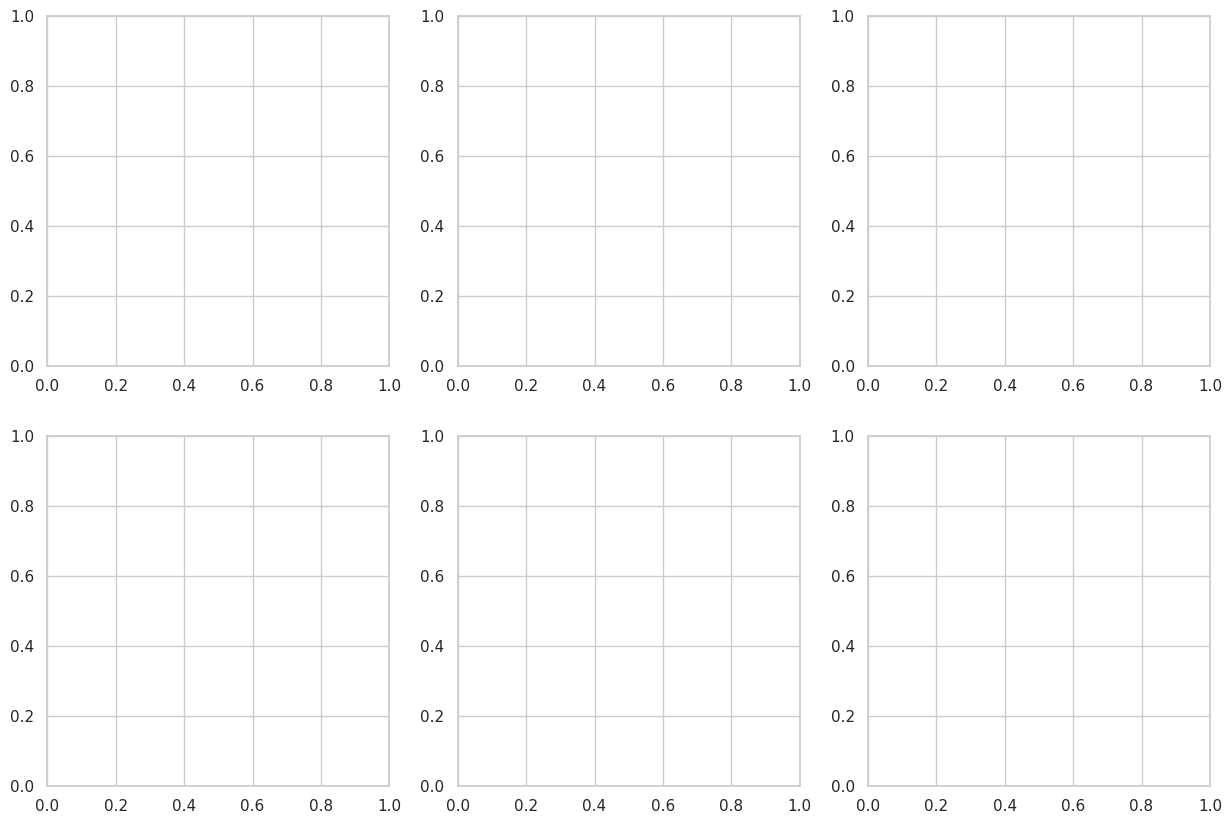

In [65]:
# ===========================
# VISUALISATION
# ===========================
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="deep", font_scale=1.0)
metrics = ["accuracy", "f1", "recall", "precision", "auc"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(results_df["labels_used"], results_df[f"{metric}_random_sampling"], 
            'o-', label="Random", color=colors[0], linewidth=2, markersize=3)
    
    ax.plot(results_df["labels_used"], results_df[f"{metric}_uncertainty_sampling"], 
            's-', label="Uncertainty", color=colors[1], linewidth=2, markersize=3)
    
    ax.plot(results_df["labels_used"], results_df[f"{metric}_llm_sampling"], 
            '^-', label="LLM", color=colors[2], linewidth=2, markersize=3)
    
    ax.set_title(metric.upper(), fontsize=12, fontweight='bold')
    ax.set_xlabel("Labels utilisés")
    ax.set_ylabel(metric.upper())
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

fig.delaxes(axes[5])

plt.suptitle("Comparaison Active Learning: Random vs Uncertainty vs LLM", 
             fontsize=14, fontweight='bold')
plt.tight_layout()

plt.savefig('active_learning_results.png', dpi=150, bbox_inches='tight')
print("✓ Graphique sauvegardé: active_learning_results.png")
plt.show()